# Analysis of results

In [21]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import pingouin as pg

from statsmodels.stats.inter_rater import aggregate_raters
from statsmodels.stats.multitest import multipletests

%matplotlib inline

# Load and merge data

In [22]:
df = pd.read_csv('data/ratings.csv')
df.columns

# rename multiple columns in dataframe
df = df.rename(columns={'quelle': 'source', 
           'thema': 'topic',
           'erstellt': 'created',
           'selbsteinschaetzung-sprache': 'Self-assessment English skills',
           'themenbezogenheit' : 'Topic and completeness',
           'logik-des-aufbaus': 'Logic and composition',
           'ausfuehrlichkeit-aussagekraft': 'Expressiveness and compr.',
           'sprachbeherrschung': 'Language mastery',
           'komplexitaet': 'Complexity',
           'gebrauch-sprachlicher-strukturen': 'Language constructs',
           'wortschatz-textverknuepfung': 'Vocabulary and text linking',
           'selbsteinschaetzung-bewertung': 'Self-assessment Assessment'})

criteria = ['Topic and completeness', 'Logic and composition', 'Expressiveness and compr.', 'Language mastery', 'Complexity', 'Vocabulary and text linking', 'Language constructs']
linguistic_markers = ['sent_complex_depth', 'sent_complex_tags', 'LD', 'dm_per_sent', 'modals_all', 'nom_per_sent', 'ep_per_sent']

essays = pd.read_csv('data/essays-with-linguistic-markers.csv')
essays.sort_values(by='Topic', ascending=True)

rating_map = {'Topic and completeness':'Topic',
              'Logic and composition': 'Logic',
              'Expressiveness and compr.': 'Expressiveness',
              'Language mastery': 'LangMastery',
              'Complexity': 'Complexity',
              'Vocabulary and text linking': 'Vocab',
              'Language constructs': 'LangConstructs'}

marker_map = {'sent_complex_depth': 'Sentence complexity (depth)',
              'sent_complex_tags': 'Sentence complexity (tags)',
              'LD': 'Linguisitic diversity',
              'dm_per_sent': 'Discourse markers',
              'modals_all': 'Modals',
              'nom_per_sent': 'Nominalizations',
              'ep_per_sent': 'Epistemic markers'}

for col in df.columns:
    if col in ['session', 'source', 'topic', 'created', 'Self-assessment English skills', 'Self-assessment Assessment']:
        continue

    stud_means = df[df['source']=='Student'].groupby('topic').mean(numeric_only=True)
    gpt3_means = df[df['source']=='ChatGPT-3'].groupby('topic').mean(numeric_only=True)
    gpt4_means = df[df['source']=='ChatGPT-4'].groupby('topic').mean(numeric_only=True)

    essays = essays.merge(stud_means[col], left_on='Topic', right_index=True, how='left').rename(columns={col:'STUD_'+rating_map[col]})
    essays = essays.merge(gpt3_means[col], left_on='Topic', right_index=True, how='left').rename(columns={col:'GPT3_'+rating_map[col]})
    essays = essays.merge(gpt4_means[col], left_on='Topic', right_index=True, how='left').rename(columns={col:'GPT4_'+rating_map[col]})

essays.to_csv('data/essays-with-linguistic-markers-and-ratings.csv', index=False)


# Participation data

## Ratings per particpant

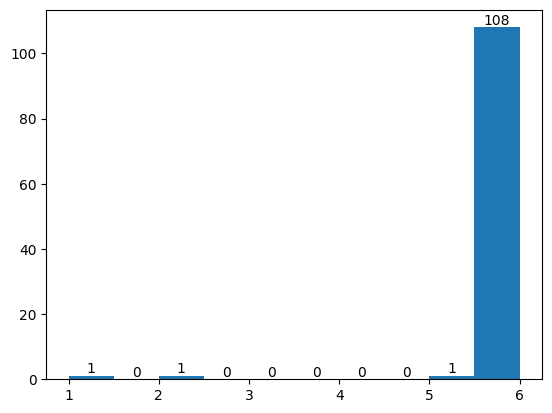

In [23]:
counts, edges, bars = plt.hist(df.groupby('session').count()['source'])
plt.bar_label(bars)
plt.show()

## Ratings per essay topic

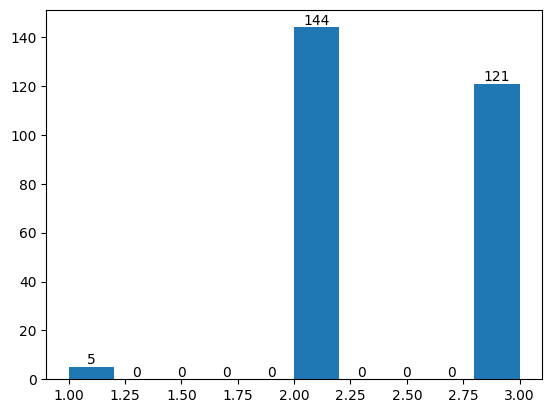

In [24]:
counts, edges, bars = plt.hist(df.groupby(['topic', 'source']).count()['session'])
plt.bar_label(bars)
plt.show()

# Plots

## Distribution of essay ratings by criteria

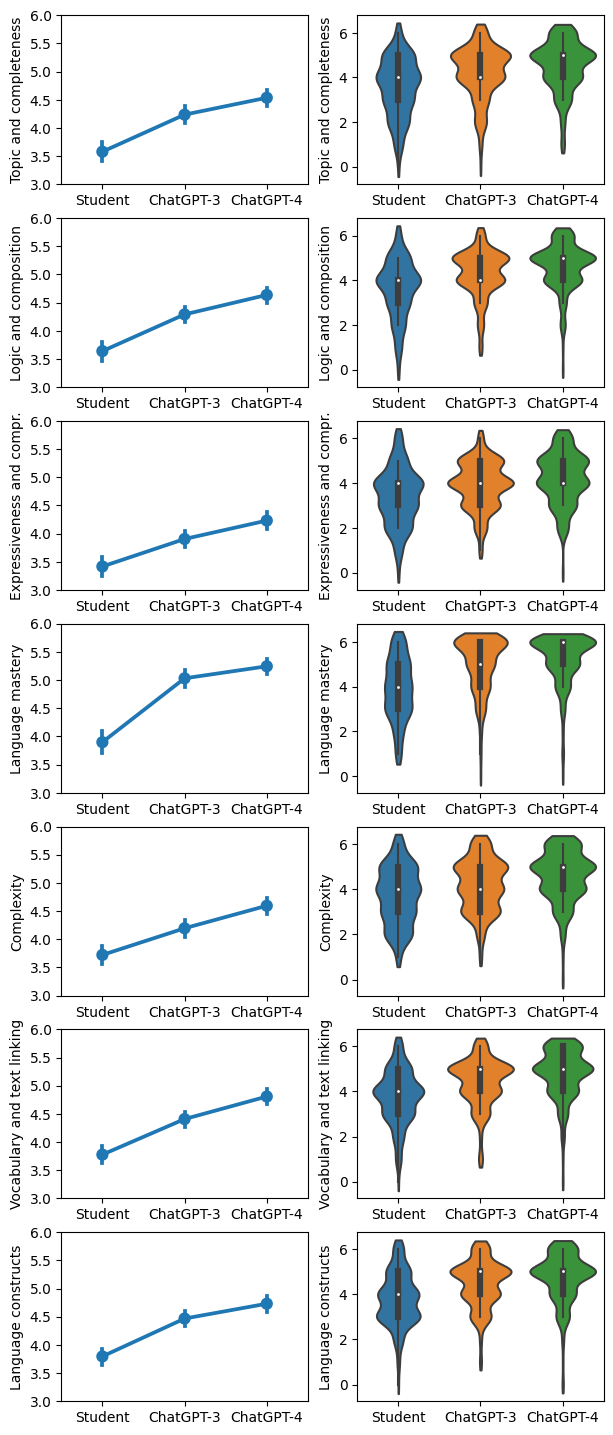

In [25]:
fig, axes = plt.subplots(7,2, figsize=(7, 18))

i=0
for criterion in criteria:
    sns.pointplot(data=df, x='source', y=criterion, order=['Student', 'ChatGPT-3', 'ChatGPT-4'], errorbar='ci', ax=axes[i,0])
    sns.violinplot(data=df, x='source', y=criterion, order=['Student', 'ChatGPT-3', 'ChatGPT-4'], cut=True, ax=axes[i,1])
    axes[i, 0].set_xlabel('')
    axes[i, 1].set_xlabel('')
    axes[i, 0].set_ylim(3, 6)
    i += 1

plt.savefig('plots/figure-2-plots_criteria.png', bbox_inches='tight')
plt.show()


## Distribution of linguistic markers

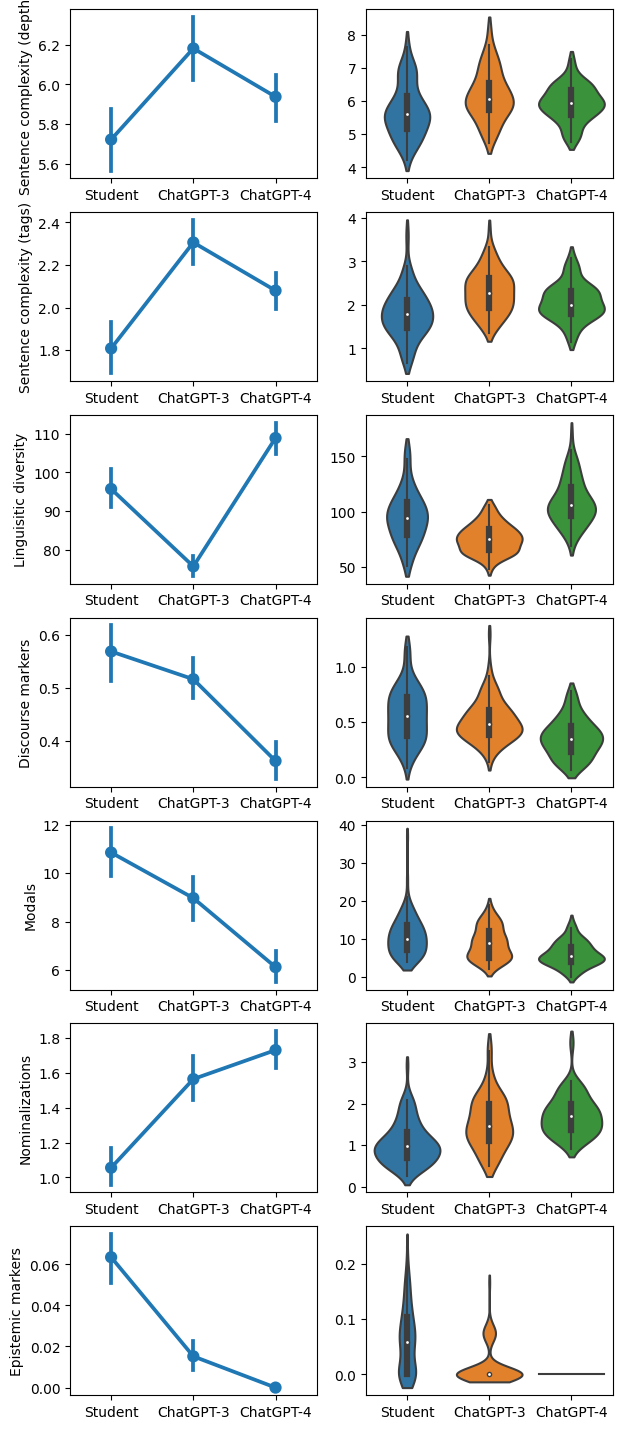

In [26]:
fig, axes = plt.subplots(7,2, figsize=(7, 18))

i=0
for marker in linguistic_markers:
    data = essays[['STUD_%s' % marker, 'GPT3_%s' % marker, 'GPT4_%s' % marker]]
    data.columns = ['Student', 'ChatGPT-3', 'ChatGPT-4']
    sns.pointplot(data=data, errorbar='ci', ax=axes[i,0])
    sns.violinplot(data=data, cut=True, ax=axes[i,1])
    axes[i, 0].set_xlabel('')
    axes[i, 1].set_xlabel('')
    axes[i, 0].set_ylabel(marker_map[marker])
    i += 1

plt.savefig('plots/figure-3-plots_linguistics.png', bbox_inches='tight')
plt.show()


# Descriptive statistics and inter-rater agreements

In [27]:
def calc_alpha(pivot_df):
    ratings = aggregate_raters(pivot_df_stud)
    rat_votes = ratings[0][:,:-1]
    rat_cats = ratings[1][:-1]
    ratings = (rat_votes, rat_cats)
    return pg.cronbach_alpha(data=pd.DataFrame(ratings[0]).transpose())

for criterion in criteria:
    pivot_df_stud = df.loc[df['source'] == 'Student', ['session', 'topic', criterion]].pivot(index='session', columns='topic', values=criterion).transpose()
    pivot_df_gpt3 = df.loc[df['source'] == 'ChatGPT-3', ['session', 'topic', criterion]].pivot(index='session', columns='topic', values=criterion).transpose()
    pivot_df_gpt4 = df.loc[df['source'] == 'ChatGPT-4', ['session', 'topic', criterion]].pivot(index='session', columns='topic', values=criterion).transpose()

    alpha_stud = calc_alpha(pivot_df_stud)
    alpha_gpt3 = calc_alpha(pivot_df_gpt3)
    alpha_gpt4 = calc_alpha(pivot_df_gpt4)

    print('%s & %.2f & %.2f & %.2f & %.2f & %.2f & %.2f & %.2f & %.2f & %.2f \\\\' % (criterion,
                                                                                      df[df['source']=='Student'].mean(numeric_only=True)[criterion],
                                                                                      df[df['source']=='Student'].std(numeric_only=True)[criterion],
                                                                                      alpha_stud[0],
                                                                                      df[df['source']=='ChatGPT-3'].mean(numeric_only=True)[criterion],
                                                                                      df[df['source']=='ChatGPT-3'].std(numeric_only=True)[criterion],
                                                                                      alpha_gpt3[0],
                                                                                      df[df['source']=='ChatGPT-4'].mean(numeric_only=True)[criterion],
                                                                                      df[df['source']=='ChatGPT-4'].std(numeric_only=True)[criterion],
                                                                                      alpha_gpt4[0]))


print('Overall & %.2f & %.2f & & %.2f & %.2f & & %.2f & %.2f & \\\\' % (df.loc[df['source']=='Student', criteria].mean(numeric_only=True).mean(),
                                                                        df.loc[df['source']=='Student', criteria].stack().std(),
                                                                        df.loc[df['source']=='ChatGPT-3', criteria].mean(numeric_only=True).mean(),
                                                                        df.loc[df['source']=='ChatGPT-3', criteria].stack().std(),
                                                                        df.loc[df['source']=='ChatGPT-4', criteria].mean(numeric_only=True).mean(),
                                                                        df.loc[df['source']=='ChatGPT-4', criteria].stack().std()))

print()

for marker in linguistic_markers:
    print('%s & %.2f & %.2f & & %.2f & %.2f & & %.2f & %.2f & \\\\' % (marker_map[marker],
                                                                        essays['STUD_%s' % marker].mean(),
                                                                        essays['STUD_%s' % marker].std(),
                                                                        essays['GPT3_%s' % marker].mean(),
                                                                        essays['GPT3_%s' % marker].std(),
                                                                        essays['GPT4_%s' % marker].mean(),
                                                                        essays['GPT4_%s' % marker].std()))

Topic and completeness & 3.58 & 1.30 & 0.95 & 4.24 & 1.16 & 0.95 & 4.54 & 1.12 & 0.95 \\
Logic and composition & 3.64 & 1.27 & 0.96 & 4.29 & 1.04 & 0.96 & 4.64 & 1.01 & 0.96 \\
Expressiveness and compr. & 3.42 & 1.25 & 0.95 & 3.90 & 1.04 & 0.95 & 4.23 & 1.12 & 0.95 \\
Language mastery & 3.90 & 1.37 & 0.89 & 5.03 & 1.19 & 0.89 & 5.25 & 1.08 & 0.89 \\
Complexity & 3.72 & 1.26 & 0.92 & 4.20 & 1.14 & 0.92 & 4.60 & 1.10 & 0.92 \\
Vocabulary and text linking & 3.78 & 1.18 & 0.97 & 4.41 & 1.05 & 0.97 & 4.81 & 1.06 & 0.97 \\
Language constructs & 3.80 & 1.15 & 0.97 & 4.47 & 1.02 & 0.97 & 4.73 & 1.07 & 0.97 \\
Overall & 3.69 & 1.26 & & 4.36 & 1.14 & & 4.68 & 1.11 & \\

Sentence complexity (depth) & 5.72 & 0.80 & & 6.18 & 0.76 & & 5.94 & 0.54 & \\
Sentence complexity (tags) & 1.81 & 0.57 & & 2.31 & 0.50 & & 2.08 & 0.42 & \\
Linguisitic diversity & 95.72 & 23.50 & & 75.68 & 12.89 & & 108.91 & 20.73 & \\
Discourse markers & 0.57 & 0.24 & & 0.52 & 0.19 & & 0.36 & 0.17 & \\
Modals & 10.84 & 5.30 & &

# Correlation analysis

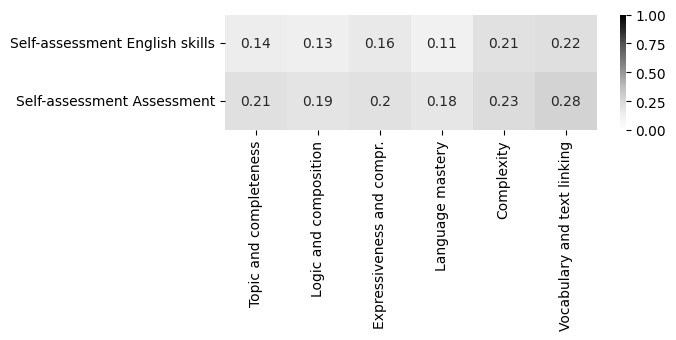

In [28]:
plt.subplots(figsize=(6,1.5))
sns.heatmap(df.corr(method='pearson', numeric_only=True).iloc[[0,-1], 1:-2], annot=True, vmin=0, vmax=1, cmap='Greys')
plt.savefig('plots/figure-1-selfassessment-correlation.png', bbox_inches='tight')
plt.show()

In [29]:
pairs = [['sent_complex_depth', 'Complexity'],
         ['sent_complex_tags', 'Complexity'],
         ['nom_per_sent', 'Complexity'],
         ['dm_per_sent', 'Logic'],
         ['LD', 'Vocab']]

for pair in pairs:
    stacked_data_0 = essays[['STUD_%s' % pair[0], 'GPT3_%s' % pair[0], 'GPT4_%s' % pair[0]]].stack()
    stacked_data_1 = essays[['STUD_%s' % pair[1], 'GPT3_%s' % pair[1], 'GPT4_%s' % pair[1]]].stack()
    print('Correlation between %s and %s: %.5f' % (pair[0], pair[1], np.corrcoef(stacked_data_0, stacked_data_1)[0,1]))

Correlation between sent_complex_depth and Complexity: 0.15874
Correlation between sent_complex_tags and Complexity: 0.19055
Correlation between nom_per_sent and Complexity: 0.22169
Correlation between dm_per_sent and Logic: -0.14180
Correlation between LD and Vocab: 0.12000


# Statistical tests

In [30]:
def _pooled_std(x, y):
    """
    Calculate the pooled standard deviation of x and y. Reused from autorank package.
    """
    nx = len(x)
    ny = len(y)
    dof = nx + ny - 2
    return np.sqrt(((nx - 1) * np.std(x, ddof=1) ** 2 + (ny - 1) * np.std(y, ddof=1) ** 2) / dof)


def cohen_d(x, y):
    """
    Calculate the effect size using Cohen's d. Reused from autorank package.
    """
    return (np.mean(x) - np.mean(y)) / _pooled_std(x, y)

tests = []
pvals = []
effect_sizes = []

# first run all tests

for col in df.columns:
    if col in ['session', 'source', 'topic', 'created', 'Self-assessment English skills', 'Self-assessment Assessment']:
        continue   
    # statistical tests
    pivot_df_stud = df.loc[df['source'] == 'Student', ['session', 'topic', col]].pivot(index='session', columns='topic', values=col)
    pivot_df_gpt3 = df.loc[df['source'] == 'ChatGPT-3', ['session', 'topic', col]].pivot(index='session', columns='topic', values=col)
    pivot_df_gpt4 = df.loc[df['source'] == 'ChatGPT-4', ['session', 'topic', col]].pivot(index='session', columns='topic', values=col)

    tests.append('stud_vs_gpt3_%s' % col)
    pvals.append(stats.wilcoxon(pivot_df_stud.mean(), pivot_df_gpt3.mean()).pvalue)
    effect_sizes.append(cohen_d(pivot_df_stud.mean(), pivot_df_gpt3.mean()))
    tests.append('stud_vs_gpt4_%s' % col)
    pvals.append(stats.wilcoxon(pivot_df_stud.mean(), pivot_df_gpt4.mean()).pvalue)
    effect_sizes.append(cohen_d(pivot_df_stud.mean(), pivot_df_gpt4.mean()))
    tests.append('gpt3_vs_gpt4_%s' % col)
    pvals.append(stats.wilcoxon(pivot_df_gpt3.mean(), pivot_df_gpt4.mean()).pvalue)
    effect_sizes.append(cohen_d(pivot_df_gpt3.mean(), pivot_df_gpt4.mean()))

for marker in linguistic_markers:
    tests.append('stud_vs_gpt3_%s' % marker)
    pvals.append(stats.wilcoxon(essays['STUD_'+marker], essays['GPT3_'+marker]).pvalue)
    effect_sizes.append(cohen_d(essays['STUD_'+marker], essays['GPT3_'+marker]))
    tests.append('stud_vs_gpt4_%s' % marker)
    pvals.append(stats.wilcoxon(essays['STUD_'+marker], essays['GPT4_'+marker]).pvalue)
    effect_sizes.append(cohen_d(essays['STUD_'+marker], essays['GPT4_'+marker]))
    tests.append('gpt3_vs_gpt4_%s' % marker)
    pvals.append(stats.wilcoxon(essays['GPT3_'+marker], essays['GPT4_'+marker]).pvalue)
    effect_sizes.append(cohen_d(essays['GPT3_'+marker], essays['GPT4_'+marker]))


# Then conduct Bonferroni-Holm correction
reject, pvals_corrected, _, _ = multipletests(pvals, alpha=0.05, method='holm')
test_results = pd.DataFrame({'test': tests, 'pval': pvals, 'pval_corrected': pvals_corrected, 'reject': reject, 'effect_size': effect_sizes})

display(test_results)

# finally output results
for col in df.columns:
    if col in ['session', 'source', 'topic', 'created', 'Self-assessment English skills', 'Self-assessment Assessment']:
        continue
    
    mask_stud_vs_gpt3 = test_results['test'] == 'stud_vs_gpt3_%s' % col
    mask_stud_vs_gpt4 = test_results['test'] == 'stud_vs_gpt4_%s' % col
    mask_gpt3_vs_gpt4 = test_results['test'] == 'gpt3_vs_gpt4_%s' % col

    print('%s & %.3f (d=%.2f) & %.3f (d=%.2f) & %.3f (d=%.2f) \\\\' % (col,
                                                                       test_results[mask_stud_vs_gpt3]['pval_corrected'].values[0],
                                                                       test_results[mask_stud_vs_gpt3]['effect_size'].values[0],
                                                                       test_results[mask_stud_vs_gpt4]['pval_corrected'].values[0],
                                                                       test_results[mask_stud_vs_gpt4]['effect_size'].values[0],
                                                                       test_results[mask_gpt3_vs_gpt4]['pval_corrected'].values[0],
                                                                       test_results[mask_gpt3_vs_gpt4]['effect_size'].values[0]))

for marker in linguistic_markers:
    mask_stud_vs_gpt3 = test_results['test'] == 'stud_vs_gpt3_%s' % marker
    mask_stud_vs_gpt4 = test_results['test'] == 'stud_vs_gpt4_%s' % marker
    mask_gpt3_vs_gpt4 = test_results['test'] == 'gpt3_vs_gpt4_%s' % marker

    print('%s & %.3f (d=%.2f) & %.3f (d=%.2f) & %.3f (d=%.2f) \\\\' % (marker_map[marker],
                                                                       test_results[mask_stud_vs_gpt3]['pval_corrected'].values[0],
                                                                       test_results[mask_stud_vs_gpt3]['effect_size'].values[0],
                                                                       test_results[mask_stud_vs_gpt4]['pval_corrected'].values[0],
                                                                       test_results[mask_stud_vs_gpt4]['effect_size'].values[0],
                                                                       test_results[mask_gpt3_vs_gpt4]['pval_corrected'].values[0],
                                                                       test_results[mask_gpt3_vs_gpt4]['effect_size'].values[0]))


,test,pval,pval_corrected,reject,effect_size
0,stud_vs_gpt3_Topic and completeness,1.699268e-06,3.738391e-05,True,-0.768313
1,stud_vs_gpt4_Topic and completeness,6.543896e-10,2.094047e-08,True,-1.091080
2,gpt3_vs_gpt4_Topic and completeness,1.897760e-02,9.488799e-02,False,-0.362975
3,stud_vs_gpt3_Logic and composition,1.086046e-07,2.715114e-06,True,-0.835831
4,stud_vs_gpt4_Logic and composition,1.967821e-10,6.887372e-09,True,-1.204023
5,gpt3_vs_gpt4_Logic and composition,3.183363e-03,2.546690e-02,True,-0.446451
6,stud_vs_gpt3_Expressiveness and compr.,5.709469e-04,8.564203e-03,True,-0.566202
7,stud_vs_gpt4_Expressiveness and compr.,5.707099e-08,1.483846e-06,True,-0.875847
8,gpt3_vs_gpt4_Expressiveness and compr.,7.874296e-03,5.512007e-02,False,-0.415070
9,stud_vs_gpt3_Language mastery,2.679977e-10,9.111920e-09,True,-1.154199


Topic and completeness & 0.000 (d=-0.77) & 0.000 (d=-1.09) & 0.095 (d=-0.36) \\
Logic and composition & 0.000 (d=-0.84) & 0.000 (d=-1.20) & 0.025 (d=-0.45) \\
Expressiveness and compr. & 0.009 (d=-0.57) & 0.000 (d=-0.88) & 0.055 (d=-0.42) \\
Language mastery & 0.000 (d=-1.15) & 0.000 (d=-1.43) & 0.105 (d=-0.26) \\
Complexity & 0.025 (d=-0.52) & 0.000 (d=-0.99) & 0.025 (d=-0.48) \\
Vocabulary and text linking & 0.000 (d=-0.76) & 0.000 (d=-1.27) & 0.013 (d=-0.50) \\
Language constructs & 0.000 (d=-0.82) & 0.000 (d=-1.15) & 0.105 (d=-0.33) \\
Sentence complexity (depth) & 0.001 (d=-0.59) & 0.055 (d=-0.32) & 0.105 (d=0.37) \\
Sentence complexity (tags) & 0.000 (d=-0.93) & 0.005 (d=-0.54) & 0.024 (d=0.49) \\
Linguisitic diversity & 0.000 (d=1.06) & 0.001 (d=-0.60) & 0.000 (d=-1.93) \\
Discourse markers & 0.150 (d=0.24) & 0.000 (d=0.98) & 0.000 (d=0.85) \\
Modals & 0.025 (d=0.39) & 0.000 (d=1.08) & 0.000 (d=0.76) \\
Nominalizations & 0.000 (d=-0.88) & 0.000 (d=-1.35) & 0.020 (d=-0.29) \\
Epi